# Logistic Regression 

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt  
import seaborn as sns
import nltk  # for text manipulation 

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import GridSearchCV, train_test_split
# from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, average_precision_score, precision_recall_curve

In [2]:
#keep the same random state for reproducibility
RANDOM_STATE = 12
TRAIN_TEST_SPLIT_SIZE = .1

**Logistic regression**


Logistic Regression is a classification algorithm. It is used to predict a binary outcome (1 / 0, Yes / No, True / False) given a set of independent variables. We can also think of logistic regression as a special case of linear regression when the outcome variable is categorical, where we are using log of odds as the dependent variable. In simple words, it predicts the probability of occurrence of an event by fitting data to a logit function.

For this part I will perform the following steps:
- Evaluate the logistic regression
- Tune the regularization strength parameter with cross-validated grid-search for each type of embeddings
- Check the predictions against the actual values

***

**Utility Functions**

***

In order to evaluate the performance of the model, I will take a look at the following metrics:
- Precision: the fraction of relevant instances among the retrieved instances.
- Recall: the fraction of the total amount of relevant instances that were actually retrieved.
- F1 Score: harmonic mean between precision and recall. Since it is difficult to compare two models with low precision and high recall or vice versa, we make them comparable by using the F-Score. F-score helps to measure Recall and Precision at the same time. It uses harmonic mean in place of arithmetic mean by punishing the extreme values more. The F1 score is highly influenced by which class is labeled as positive. 
- Confusion Matrix: a summary table that breaks down the number of correct and incorrect predictions by each class. For imbalanced classification problems, the majority class is typically referred to as the negative outcome (e.g. such as “no change” or “negative test result“), and the minority class is typically referred to as the positive outcome (e.g. “change” or “positive test result”). The confusion matrix provides more insight into not only the performance of a predictive model, but also which classes are being predicted correctly, which incorrectly, and what type of errors are being made. The simplest confusion matrix is for a two-class classification problem, with negative (class 0) and positive (class 1) classes. I will reverse the positive and the negative labels in the calculation of the confusion matrix to reflect my actual labeling of the classes (majority class is label 0 and minority class is label 1).
- ROC: a plot that illustrates the true positive rate against the false positive rate at various threshold settings. The area under the curve (AUC) indicates the probability that the classifier will rank a randomly chosen positive observation higher than a randomly chosen negative one.

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
def plot_cfm(labels, predictions, p = 0.5):
    cfm = metrics.confusion_matrix(labels, predictions > p)
    plt.figure(figsize = (5,5))
    sns.heatmap(cfm, annot = True, fmt = "d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual values')
    plt.xlabel('Predicted values')

    print('True Negatives: ', cfm[0][0])
    print('False Positives: ', cfm[0][1])
    print('False Negatives: ', cfm[1][0])
    print('True Positives: ', cfm[1][1])

In [5]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    roc_auc = metrics.auc(fp, tp)    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fp, tp, label = name + ' AUC = %0.2f' % roc_auc, linewidth=2, **kwargs)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linewidth=2, color=colors[6], linestyle=':')
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

***

**TF-IDF**

***

**Prepare the datasets**

Here we will use the TF-IDF extracted features and combine again the train and validation data set, since we will use GridSeachCV with built-in cross-validation to look for the best parameters. 

In [6]:
train_tfidf_features = np.load('train_dataset_tfidf_features.npy', allow_pickle=True)
train_tfidf_labels = np.load('train_dataset_tfidf_labels.npy', allow_pickle=True)

In [7]:
test_tfidf_features = np.load('test_dataset_tfidf_features.npy', allow_pickle=True)
test_tfidf_labels = np.load('test_dataset_tfidf_labels.npy', allow_pickle=True)

In [8]:
val_tfidf_features = np.load('val_dataset_tfidf_features.npy', allow_pickle=True)
val_tfidf_labels = np.load('val_dataset_tfidf_labels.npy', allow_pickle=True)

In [9]:
# Create X/y arrays
x_train_tfidf_u = train_tfidf_features.item()
y_train_tfidf_u = train_tfidf_labels

print('x:', x_train_tfidf_u.shape, x_train_tfidf_u.dtype)
print('y:', y_train_tfidf_u.shape, y_train_tfidf_u.dtype)

x: (54706, 25000) float64
y: (54706,) int64


In [10]:
# Create X/y arrays
x_test_tfidf = test_tfidf_features.item()
y_test_tfidf = test_tfidf_labels

print('x:', x_test_tfidf.shape, x_test_tfidf.dtype)
print('y:', y_test_tfidf.shape, y_test_tfidf.dtype)

x: (7599, 25000) float64
y: (7599,) int64


In [11]:
# Create X/y arrays
x_val_tfidf = val_tfidf_features.item()
y_val_tfidf = val_tfidf_labels

print('x:', x_val_tfidf.shape, x_val_tfidf.dtype)
print('y:', y_val_tfidf.shape, y_val_tfidf.dtype)

x: (13677, 25000) float64
y: (13677,) int64


In [12]:
import scipy
x_train_tfidf = scipy.sparse.vstack([x_train_tfidf_u, x_val_tfidf])
y_train_tfidf = np.hstack((y_train_tfidf_u, y_val_tfidf))

In [13]:
print('x:', x_train_tfidf.shape, x_train_tfidf.dtype)
print('y:', y_train_tfidf.shape, y_train_tfidf.dtype)

x: (68383, 25000) float64
y: (68383,) int64


Normally, at this stage I would normalize the input features using the sklearn StandardScaler. This will set the mean to 0 and standard deviation to 1. However, "smart" vectorizers, such as tfidf are actually already doing that. The idf transformation is supposed to create a kind of reasonable data scaling. There is no guarantee which one will be better, but in general, tfidf should be enough. 

**Hyperparameter Tuning**

The logistic regression does not really have any critical hyperparameters to tune.
The C parameter controls the penality strength. Typically is a positive floating-point number (1.0 by default) that defines the relative strength of regularization. Smaller values indicate stronger regularization, bigger values indicate a weaker regularization. I will try with a very strong and a very weak regularization strength, and pass ten C values on a log scale between 10^(-4) and 10^4. I will also set the cv strategy to 5-fold cross-validation, which is stratified by default for classification tasks. cv=5 is also the standard value, which has been shown to yield test error rate estimates that suffer neither from excessively high bias nor from very high variance.
I also use roc_auc and f1 as scoring, but refit on f1.

**Solver Options**

Scikit-learn ships with five different solvers. Each solver tries to find the parameter weights that minimize a cost function. Here is a brief overview of the five options:
- newton-cg — A newton method. Newton methods use an exact Hessian matrix. It's slow for large datasets, because it computes the second derivatives.
- lbfgs — Stands for Limited-memory Broyden–Fletcher–Goldfarb–Shanno. It approximates the second derivative matrix updates with gradient evaluations. It stores only the last few updates, so it saves memory. It isn't super fast with large data sets. It will be the default solver as of Scikit-learn version 0.22.0.
- liblinear — Library for Large Linear Classification. Uses a coordinate descent algorithm. Coordinate descent is based on minimizing a multivariate function by solving univariate optimization problems in a loop. In other words, it moves toward the minimum in one direction at a time. It is the default solver for Scikit-learn versions earlier than 0.22.0. It performs pretty well with high dimensionality, but it does have a number of drawbacks though. It can get stuck, and it is unable to run in parallel.
- sag — Stochastic Average Gradient descent. A variation of gradient descent and incremental aggregated gradient approaches that uses a random sample of previous gradient values. Fast for big datasets.
- saga — Extension of sag that also allows for L1 regularization. Should generally train faster than sag.

In [14]:
SCORING = {'Accuracy': 'accuracy', 'F1': 'f1'}
C_SPACE = np.logspace(-2, 4, num = 10)

PARAMETERS = {
            'C': C_SPACE,
            'solver': ['lbfgs', 'liblinear', 'saga'],
            }
MAX_ITER = 1000 

In [15]:
lr = LogisticRegression(max_iter = MAX_ITER)
gs = GridSearchCV(lr, PARAMETERS, cv = 5, scoring = SCORING, refit = 'F1', return_train_score = True, verbose = 3, n_jobs = -1)

In [16]:
gs.fit(x_train_tfidf, y_train_tfidf)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': array([1.00000000e-02, 4.64158883e-02, 2.15443469e-01, 1.00000000e+00,
       4.64158883e+00, 2.15443469e+01, 1.00000000e+02, 4.64158883e+02,
       2.15443469e+03, 1.00000000e+04]),
                         'solver': ['lbfgs', 'liblinear', 'saga']},
             refit='F1', return_train_score=True,
             scoring={'Accuracy': 'accuracy', 'F1': 'f1'}, verbose=3)

In [17]:
print(gs.best_params_) 
print(gs.best_score_) 
print(gs.best_estimator_) 

{'C': 21.54434690031882, 'solver': 'saga'}
0.9605398889244607
LogisticRegression(C=21.54434690031882, max_iter=1000, solver='saga')


In [18]:
logreg = gs.best_estimator_

In [19]:
# Fit it to train data
logreg.fit(x_train_tfidf, y_train_tfidf)

LogisticRegression(C=21.54434690031882, max_iter=1000, solver='saga')

In [20]:
y_pred_test_tfidf = logreg.predict(x_test_tfidf)

In [21]:
y_probas_train_tfidf = logreg.decision_function(x_train_tfidf)
y_probas_test_tfidf = logreg.decision_function(x_test_tfidf)

True Negatives:  3551
False Positives:  159
False Negatives:  121
True Positives:  3768


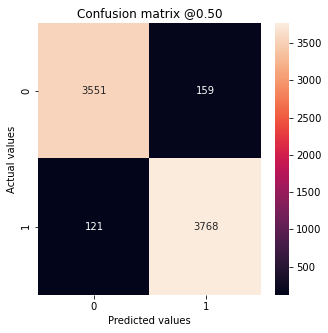

In [22]:
plot_cfm(y_test_tfidf, y_pred_test_tfidf)

In [23]:
print(classification_report(y_test_tfidf, y_pred_test_tfidf))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      3710
           1       0.96      0.97      0.96      3889

    accuracy                           0.96      7599
   macro avg       0.96      0.96      0.96      7599
weighted avg       0.96      0.96      0.96      7599



In [24]:
f1_tfidf = f1_score(y_test_tfidf, y_pred_test_tfidf, average = 'weighted')
print('F1: %.2f' % f1_tfidf)

F1: 0.96


In [25]:
auc_tfidf = roc_auc_score(y_test_tfidf, y_probas_test_tfidf)
print('AUC: %.2f' % auc_tfidf)

AUC: 0.99


AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0's as 0's and 1's as 1's. 

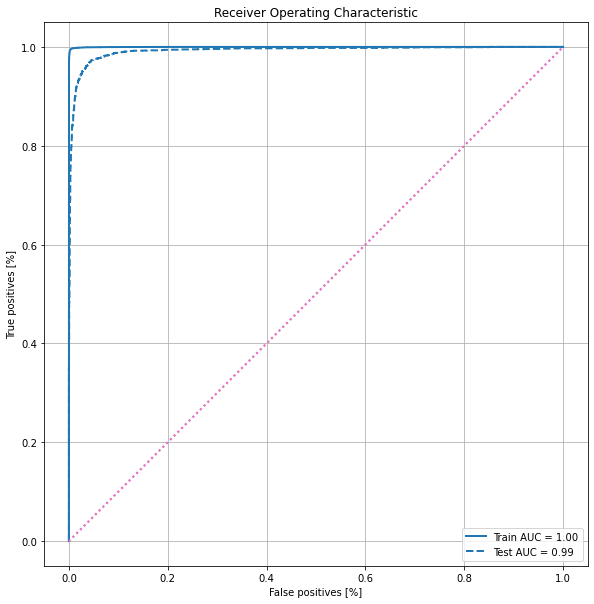

In [26]:
plot_roc("Train", y_train_tfidf, y_probas_train_tfidf, color = colors[0])
plot_roc("Test", y_test_tfidf, y_probas_test_tfidf, color = colors[0], linestyle = '--')

The AUC score for the test data set as well as the AUC - ROC curve are very consistent with respect to the training data set, and the model performs very well. 

In [27]:
import joblib
# save
joblib.dump(logreg, "./logreg.joblib")

['./logreg.joblib']

In [28]:
# Saving model to current directory
# Pickle serializes objects so they can be saved to a file, and loaded in a program again later on.
import pickle
pickle.dump(logreg, open('logreg.pkl','wb'))

#Loading model to compare the results
#model = pickle.load(open('model.pkl','rb'))